In [ ]:
# default_exp utils

# Utilities

> Helper functions used throughout the library not related to timeseries data.

In [ ]:
#export
from tsai.imports import *
from fastcore.test import *

In [ ]:
#hide
import tsai
a = !python  -V
p = a[0].split(' ')
print(f'python         : {p[1]}')
print('tsai           :', tsai.__version__)
print('fastai         :', fastai.__version__)
print('fastcore       :', fastcore.__version__)
print('torch          :', torch.__version__)
print('scipy          :', sp.__version__)
print('numpy          :', np.__version__)
print('pandas         :', pd.__version__)
print('matplotlib     :', matplotlib.__version__)

python         : 3.7.6
tsai           : 0.2.0
fastai         : 2.0.18
fastcore       : 1.2.5
torch          : 1.6.0
scipy          : 1.5.2
numpy          : 1.19.1
pandas         : 1.1.3
matplotlib     : 3.3.2


In [ ]:
#export
import inspect
import sklearn

In [ ]:
#export
def totensor(o):
    if isinstance(o, torch.Tensor): return o
    elif isinstance(o, np.ndarray):  return torch.from_numpy(o)
    elif isinstance(o, (list, L)): return torch.tensor(o)
    assert False, f"Can't convert {type(o)} to torch.Tensor"


def toarray(o):
    if isinstance(o, np.ndarray): return o
    elif isinstance(o, torch.Tensor): return o.cpu().numpy()
    elif isinstance(o, (list, L)): return np.array(o)
    assert False, f"Can't convert {type(o)} to np.array"
    
    
def toL(o):
    if isinstance(o, L): return o
    elif isinstance(o, list): return L(o)
    elif isinstance(o, (np.ndarray, torch.Tensor)): return L(o.tolist())
    assert False, f'passed object needs to be of type L, list, np.ndarray or torch.Tensor but is {type(o)}'


def to3dtensor(o):
    o = totensor(o)
    if o.ndim == 3: return o
    elif o.ndim == 1: return o[None, None]
    elif o.ndim == 2: return o[:, None]
    assert False, f'Please, review input dimensions {o.ndim}'


def to2dtensor(o):
    o = totensor(o)
    if o.ndim == 2: return o
    elif o.ndim == 1: return o[None]
    elif o.ndim == 3: return o[0]
    assert False, f'Please, review input dimensions {o.ndim}'


def to1dtensor(o):
    o = totensor(o)
    if o.ndim == 1: return o
    elif o.ndim == 3: return o[0,0]
    if o.ndim == 2: return o[0]
    assert False, f'Please, review input dimensions {o.ndim}'


def to3darray(o):
    o = toarray(o)
    if o.ndim == 3: return o
    elif o.ndim == 1: return o[None, None]
    elif o.ndim == 2: return o[:, None]
    assert False, f'Please, review input dimensions {o.ndim}'


def to2darray(o):
    o = toarray(o)
    if o.ndim == 2: return o
    elif o.ndim == 1: return o[None]
    elif o.ndim == 3: return o[0]
    assert False, f'Please, review input dimensions {o.ndim}'


def to1darray(o):
    o = toarray(o)
    if o.ndim == 1: return o
    elif o.ndim == 3: o = o[0,0]
    elif o.ndim == 2: o = o[0]
    assert False, f'Please, review input dimensions {o.ndim}'
    
    
def to3d(o):
    if o.ndim == 3: return o
    if isinstance(o, np.ndarray): return to3darray(o)
    if isinstance(o, torch.Tensor): return to3dtensor(o)
    
    
def to2d(o):
    if o.ndim == 2: return o
    if isinstance(o, np.ndarray): return to2darray(o)
    if isinstance(o, torch.Tensor): return to2dtensor(o)
    
    
def to1d(o):
    if o.ndim == 1: return o
    if isinstance(o, np.ndarray): return to1darray(o)
    if isinstance(o, torch.Tensor): return to1dtensor(o)
    
    
def to2dPlus(o):
    if o.ndim >= 2: return o
    if isinstance(o, np.ndarray): return to2darray(o)
    elif isinstance(o, torch.Tensor): return to2dtensor(o)
    
    
def to3dPlus(o):
    if o.ndim >= 3: return o
    if isinstance(o, np.ndarray): return to3darray(o)
    elif isinstance(o, torch.Tensor): return to3dtensor(o)
    
    
def to2dPlusTensor(o):
    return to2dPlus(totensor(o))


def to2dPlusArray(o):
    return to2dPlus(toarray(o))


def to3dPlusTensor(o):
    return to3dPlus(totensor(o))


def to3dPlusArray(o):
    return to3dPlus(toarray(o))


def todtype(dtype):
    def _to_type(o, dtype=dtype):
        if o.dtype == dtype: return o
        elif isinstance(o, torch.Tensor): o = o.to(dtype=dtype)
        elif isinstance(o, np.ndarray): o = o.astype(dtype)
        return o
    return _to_type

In [ ]:
a = np.random.rand(100).astype(np.float32)
b = torch.from_numpy(a).float()
test_eq(totensor(a), b)
test_eq(a, toarray(b))
test_eq(to3dtensor(a).ndim, 3)
test_eq(to2dtensor(a).ndim, 2)
test_eq(to1dtensor(a).ndim, 1)
test_eq(to3darray(b).ndim, 3)
test_eq(to2darray(b).ndim, 2)
test_eq(to1darray(b).ndim, 1)

In [ ]:
#export
def bytes2size(size_bytes):
    if size_bytes == 0: return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

def bytes2GB(byts):
    return round(byts / math.pow(1024, 3), 2)

In [ ]:
#export
def delete_all_in_dir(tgt_dir, exception=None):
    if exception is not None and len(L(exception)) > 1: exception = tuple(exception)
    for file in os.listdir(tgt_dir):
        if exception is not None and file.endswith(exception): continue
        file_path = os.path.join(tgt_dir, file)
        if os.path.isfile(file_path) or os.path.islink(file_path): os.unlink(file_path)
        elif os.path.isdir(file_path): shutil.rmtree(file_path)

In [ ]:
#export
def reverse_dict(dictionary): 
    return {v: k for k, v in dictionary.items()}

In [ ]:
#export
def is_tuple(o): return isinstance(o, tuple)

In [ ]:
#export
def itemify(*o, tup_id=None): 
    o = [o_ for o_ in L(*o) if o_ is not None]
    items = L(o).zip()
    if tup_id is not None: return L([item[tup_id] for item in items])
    else: return items

In [ ]:
a = [1, 2, 3]
b = [4, 5, 6]
print(itemify(a, b))
test_eq(len(itemify(a, b)), len(a))
a = [1, 2, 3]
b = None
print(itemify(a, b))
test_eq(len(itemify(a, b)), len(a))
a = [1, 2, 3]
b = [4, 5, 6]
c = None
print(itemify(a, b, c))
test_eq(len(itemify(a, b, c)), len(a))

[(1, 4), (2, 5), (3, 6)]
[(1,), (2,), (3,)]
[(1, 4), (2, 5), (3, 6)]


In [ ]:
#export
def isnone(o):
    return o is None

def exists(o): return o is not None

def ifelse(a, b, c):
    "`b` if `a` is True else `c`"
    return b if a else c

In [ ]:
a = np.array(3)
test_eq(isnone(a), False)
test_eq(exists(a), True)
b = None
test_eq(isnone(b), True)
test_eq(exists(b), False)

In [ ]:
#export
def is_not_close(a, b, eps=1e-5):
    "Is `a` within `eps` of `b`"
    if hasattr(a, '__array__') or hasattr(b, '__array__'):
        return (abs(a - b) > eps).all()
    if isinstance(a, (Iterable, Generator)) or isinstance(b, (Iterable, Generator)):
        return is_not_close(np.array(a), np.array(b), eps=eps)
    return abs(a - b) > eps


def test_not_close(a, b, eps=1e-5):
    "`test` that `a` is within `eps` of `b`"
    test(a, b, partial(is_not_close, eps=eps), 'not_close')


def test_type(a, b):
    return test_eq(type(a), type(b))


def test_ok(f, *args, **kwargs):
    try: 
        f(*args, **kwargs)
        e = 0
    except: 
        e = 1
        pass
    test_eq(e, 0)
    
def test_not_ok(f, *args, **kwargs):
    try: 
        f(*args, **kwargs)
        e = 0
    except: 
        e = 1
        pass
    test_eq(e, 1)
    
def test_error(error, f, *args, **kwargs):
    try: f(*args, **kwargs)
    except Exception as e: 
        test_eq(str(e), error)

In [ ]:
#export
def assert_fn(*args, **kwargs): assert False, 'assertion test'
test_error('assertion test', assert_fn, 35, a=3)

In [ ]:
#export
def test_gt(a,b):
    "`test` that `a>b`"
    test(a,b,gt,'>')

def test_ge(a,b):
    "`test` that `a>=b`"
    test(a,b,ge,'>')
    
def test_lt(a,b):
    "`test` that `a>b`"
    test(a,b,lt,'<')

def test_le(a,b):
    "`test` that `a>b`"
    test(a,b,le,'<=')

In [ ]:
test_ok(test_gt, 5, 4)
test_not_ok(test_gt, 4, 4)
test_ok(test_ge, 4, 4)
test_not_ok(test_ge, 3, 4)

test_ok(test_lt, 3, 4)
test_not_ok(test_lt, 4, 4)
test_ok(test_le, 4, 4)
test_not_ok(test_le, 5, 4)

In [ ]:
#export
def stack(o, axis=0, retain=True):
    if isinstance(o[0], torch.Tensor): 
        return retain_type(torch.stack(tuple(o), dim=axis),  o[0]) if retain else torch.stack(tuple(o), dim=axis)
    else: 
        return retain_type(np.stack(o, axis), o[0]) if retain else np.stack(o, axis)
    
def stack_pad(l):
    def resize(row, size):
        new = np.array(row)
        new.resize(size)
        return new
    row_length = max(l, key=len).__len__()
    mat = np.array([resize(row, row_length) for row in l])
    return mat

In [ ]:
a = [[0,1,2], [4,5,6,7]]
test_eq(stack_pad(a).shape, (2, 4))
test_eq(type(stack_pad(a)), np.ndarray)

In [ ]:
a = np.random.rand(2, 3, 4)
t = torch.from_numpy(a)
test_eq_type(stack(itemify(a, tup_id=0)), a)
test_eq_type(stack(itemify(t, tup_id=0)), t)

In [ ]:
#export
def random_shuffle(o, random_state=None):
    res = sklearn.utils.shuffle(o, random_state=random_state)
    if isinstance(o, L): return L(list(res))
    return res

In [ ]:
a = np.arange(10)
test_eq_type(random_shuffle(a, 1), np.array([2, 9, 6, 4, 0, 3, 1, 7, 8, 5]))
t = torch.arange(10)
test_eq_type(random_shuffle(t, 1), tensor([2, 9, 6, 4, 0, 3, 1, 7, 8, 5]))
l = list(a)
test_eq(random_shuffle(l, 1), [2, 9, 6, 4, 0, 3, 1, 7, 8, 5])
l2 = L(l)
test_eq_type(random_shuffle(l2, 1), L([2, 9, 6, 4, 0, 3, 1, 7, 8, 5]))

In [ ]:
#export
def cat2int(o):
    cat = Categorize()
    cat.setup(o)
    return stack(TfmdLists(o, cat)[:])

In [ ]:
a = np.array(['b', 'a', 'a', 'b', 'a', 'b', 'a'])
test_eq_type(cat2int(a), TensorCategory([1, 0, 0, 1, 0, 1, 0]))

In [ ]:
TensorBase([1,2,3])

TensorBase([1, 2, 3])

In [ ]:
#export
def cycle_dl(dl): 
    for _ in dl: _
        
def cycle_dl_to_device(dl):
    for bs in dl: [b.to(default_device()) for b in bs]

In [ ]:
#export
def cache_memmap(o, slice_len=1000, verbose=False):
    start = 0
    slice_len = 1000
    for i in range(len(o) // 1000 + 1): 
        o[start:start + slice_len]
        start += slice_len
        if verbose and i % 10 == 0: print(i)
    
memmap2cache =  cache_memmap

In [ ]:
#export
def get_func_defaults(f): 
    fa = inspect.getfullargspec(f)
    if fa.defaults is None: return dict(zip(fa.args, [''] * (len(fa.args))))
    else: return dict(zip(fa.args, [''] * (len(fa.args) - len(fa.defaults)) + list(fa.defaults)))

In [ ]:
#export
def get_idx_from_df_col_vals(df, col, val_list):
    return [df[df[col] == val].index[0] for val in val_list]

In [ ]:
#export
def get_sublist_idxs(aList, bList):
    "Get idxs that when applied to aList will return bList. aList must contain all values in bList"
    sorted_aList = aList[np.argsort(aList)]
    return np.argsort(aList)[np.searchsorted(sorted_aList, bList)]

In [ ]:
x = np.array([3, 5, 7, 1, 9, 8, 6, 2])
y = np.array([6, 1, 5, 7])
idx = get_sublist_idxs(x, y)
test_eq(x[idx], y)
x = np.array([3, 5, 7, 1, 9, 8, 6, 6, 2])
y = np.array([6, 1, 5, 7, 5])
idx = get_sublist_idxs(x, y)
test_eq(x[idx], y)

In [ ]:
#export
def flatten_list(l):
    return [item for sublist in l for item in sublist]

In [ ]:
#export
def display_pd_df(df, max_rows:Union[bool, int]=False, max_columns:Union[bool, int]=False):
    if max_rows:
        old_max_rows = pd.get_option('display.max_rows')
        if max_rows is not True and isinstance(max_rows, Integral): pd.set_option('display.max_rows', max_rows)
        else: pd.set_option('display.max_rows', df.shape[0])
    if max_columns:
        old_max_columns = pd.get_option('display.max_columns')
        if max_columns is not True and isinstance(max_columns, Integral): pd.set_option('display.max_columns', max_columns)
        else: pd.set_option('display.max_columns', df.shape[1])
    display(df)
    if max_rows: pd.set_option('display.max_rows', old_max_rows)
    if max_columns: pd.set_option('display.max_columns', old_max_columns)

In [ ]:
old_max_rows, old_max_columns = pd.get_option('display.max_rows'), pd.get_option('display.max_columns')
df = pd.DataFrame(np.random.rand(70, 25))
display_pd_df(df, max_rows=2, max_columns=3)
test_eq(old_max_rows, pd.get_option('display.max_rows'))
test_eq(old_max_columns, pd.get_option('display.max_columns'))

,0,...,24
0,0.685583,...,0.417709
...,...,...,...
69,0.878405,...,0.141189


In [ ]:
#export
def ttest(data1, data2, equal_var=False):
    "Calculates t-statistic and p-value based on 2 sample distributions"
    t_stat, p_value = scipy.stats.ttest_ind(data1, data2, equal_var=equal_var)
    return t_stat, np.sign(t_stat) * p_value

def tscore(o): 
    if o.std() == 0: return 0
    else: return np.sqrt(len(o)) * o.mean() / o.std()

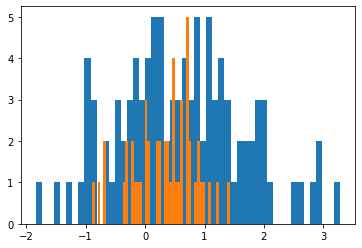

(2.1519196146539383, 0.03302563389821122)

In [ ]:
a = np.random.normal(0.5, 1, 100)
b = np.random.normal(0.15, .5, 50)
plt.hist(a, 50)
plt.hist(b, 50)
plt.show()
ttest(a,b)

In [ ]:
a = np.random.normal(0.5, 1, 100)
t = torch.normal(0.5, 1, (100, ))
tscore(a), tscore(t)

(4.839118826642744, tensor(5.2545))

In [ ]:
#export
def ttest_tensor(a, b):
    "differentiable pytorch function equivalent to scipy.stats.ttest_ind with equal_var=False"
    # calculate standard errors
    se1, se2 = torch.std(a)/np.sqrt(len(a)), torch.std(b)/np.sqrt(len(b))
    # standard error on the difference between the samples
    sed = torch.sqrt(se1**2.0 + se2**2.0)
    # calculate the t statistic
    t_stat = (torch.mean(a) - torch.mean(b)) / sed
    return t_stat

In [ ]:
a = torch.rand(100).requires_grad_(True) + .1
b = torch.rand(100).requires_grad_(True)
ttest_tensor(a, b)

tensor(4.7966, grad_fn=<DivBackward0>)

In [ ]:

#export
from scipy.stats import pearsonr, spearmanr

def pcc(a, b):
    return pearsonr(a, b)[0]

def scc(a, b):
    return spearmanr(a, b)[0]

a = np.random.normal(0.5, 1, 100)
b = np.random.normal(0.15, .5, 100)
pcc(a, b), scc(a, b)

(-0.04231948491782222, -0.07198319831983198)

In [ ]:
#export
def remove_fn(fn, verbose=False):
    "Removes a file (fn) if exists"
    try: 
        os.remove(fn)
        pv(f'{fn} file removed', verbose)
    except OSError: 
        pv(f'{fn} does not exist', verbose)
        pass

In [ ]:
fn = 'data/remove_fn_test.npy'
a = np.zeros(1)
np.save(fn, a)
remove_fn(fn, True)
remove_fn(fn, True)

data/remove_fn_test.npy file removed
data/remove_fn_test.npy does not exist


In [ ]:
#export
def npsave(array_fn, array, verbose=True):
    remove_fn(array_fn, verbose)
    pv(f'saving {array_fn}...', verbose)
    np.save(array_fn, array)
    pv(f'...{array_fn} saved', verbose)
    
np_save = npsave

In [ ]:
fn = 'data/remove_fn_test.npy'
a = np.zeros(1)
npsave(fn, a)
del a
np.load(fn, mmap_mode='r+')
remove_fn(fn, True)
remove_fn(fn, True)

data/remove_fn_test.npy does not exist
saving data/remove_fn_test.npy...
...data/remove_fn_test.npy saved
data/remove_fn_test.npy file removed
data/remove_fn_test.npy does not exist


In [ ]:
#export
def permute_2D(array, axis=None):
    "Permute rows or columns in an array. This can be used, for example, in feature permutation"
    if axis == 0: return array[np.random.randn(*array.shape).argsort(axis=0), np.arange(array.shape[-1])[None, :]] 
    elif axis == 1 or axis == -1: return array[np.arange(len(array))[:,None], np.random.randn(*array.shape).argsort(axis=1)] 
    return array[np.random.randn(*array.shape).argsort(axis=0), np.random.randn(*array.shape).argsort(axis=1)] 

In [ ]:
s = np.arange(100 * 50).reshape(100, 50) 
test_eq(permute_2D(s, axis=0).mean(0), s.mean(0))
test_ne(permute_2D(s, axis=0), s)
test_eq(permute_2D(s, axis=1).mean(1), s.mean(1))
test_ne(permute_2D(s, axis=1), s)
test_ne(permute_2D(s), s)

In [ ]:
#export
def random_normal():
    "Returns a number between -1 and 1 with a normal distribution"
    while True:
        o = np.random.normal(loc=0., scale=1/3)
        if abs(o) <= 1: break
    return o

def random_half_normal():
    "Returns a number between 0 and 1 with a half-normal distribution"
    while True:
        o = abs(np.random.normal(loc=0., scale=1/3))
        if o <= 1: break
    return o

def random_normal_tensor(shape=1, device=None):
    "Returns a tensor of a predefined shape between -1 and 1 with a normal distribution"
    return torch.empty(shape, device=device).normal_(mean=0, std=1/3).clamp_(-1, 1)

def random_half_normal_tensor(shape=1, device=None):
    "Returns a tensor of a predefined shape between 0 and 1 with a half-normal distribution"
    return abs(torch.empty(shape, device=device).normal_(mean=0, std=1/3)).clamp_(0, 1)

In [ ]:
#export
def clip_outliers(o):
    Q1, Q3 = np.percentile(o, [25, 75])
    IQR = Q3 - Q1
    if isinstance(o, (np.ndarray, pd.core.series.Series)):
        return np.clip(o, Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
    elif isinstance(o, torch.Tensor):
        return torch.clamp(o, Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

In [ ]:
#export
from matplotlib.backends.backend_agg import FigureCanvasAgg

def default_dpi():
    DPI = plt.gcf().get_dpi()
    plt.close()
    return int(DPI)

def get_plot_fig(size=None, dpi=default_dpi()):
    fig = plt.figure(figsize=(size / dpi, size / dpi), dpi=dpi, frameon=False) if size else plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    config = plt.gcf()
    plt.close('all')
    return config

def fig2buf(fig):
    canvas = FigureCanvasAgg(fig)
    fig.canvas.draw()
    return np.asarray(canvas.buffer_rgba())[..., :3]

In [ ]:
default_dpi()

72

In [ ]:
#export
def plot_scatter(x, y, deg=1):
    linreg = sp.stats.linregress(x, y)
    plt.scatter(x, y, label=f'R2:{linreg.rvalue:.2f}', color='lime', edgecolor='black', alpha=.5)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, deg))(np.unique(x)), color='r')
    plt.legend(loc='best')
    plt.show()

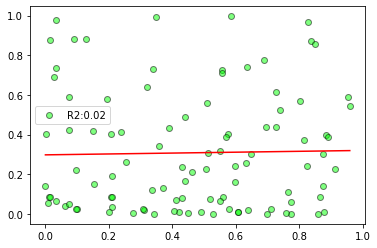

In [ ]:
a = np.random.rand(100)
b = np.random.rand(100)**2
plot_scatter(a, b)

In [ ]:
#export
import seaborn as sns
def jointplot_scatter(x,y,**kwargs):
    sns.jointplot(x, y, kind='scatter', **kwargs)
    plt.show()
    
def jointplot_kde(x,y,**kwargs):
    sns.jointplot(x, y, kind='kde', **kwargs)
    plt.show()

In [ ]:
#export
def get_idxs(o, aList): return array([o.tolist().index(v) for v in aList])

In [ ]:
a = random_shuffle(np.arange(100, 200))
b = np.random.choice(a, 10, False)
idxs = get_idxs(a, b)
test_eq(a[idxs], b)

In [ ]:
# export
def apply_cmap(o, cmap):
    o = toarray(o)
    out = plt.get_cmap(cmap)(o)[..., :3]
    out = tensor(out).squeeze(1)
    return out.permute(0, 3, 1, 2)

In [ ]:
a = np.random.rand(16, 1, 40, 50)
s = L(a.shape)
s[1] = 3
test_eq(L(apply_cmap(a, 'viridis').shape), s)

s[0] = 1
a = np.random.rand(1, 40, 50)
test_eq(L(apply_cmap(a, 'viridis').shape), s)

In [ ]:
#export
def torch_tile(a, n_tile, dim=0):
    init_dim = a.size(dim)
    repeat_idx = [1] * a.dim()
    repeat_idx[dim] = n_tile
    a = a.repeat(*(repeat_idx))
    order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)]))
    return torch.index_select(a, dim, order_index)

In [ ]:
test_eq(torch_tile(torch.arange(2), 3), tensor([0, 0, 0, 1, 1, 1]))

In [ ]:
#export
def to_tsfresh_dataset(ts):
    r"""Prepares a time series (Tensor/ np.ndarray) to be used as a tsfresh dataset to allow feature extraction"""
    if isinstance(ts, np.ndarray):
        ids = np.repeat(np.arange(len(ts)), ts.shape[-1]).reshape(-1,1)
        joint_ts =  ts.transpose(0,2,1).reshape(-1, ts.shape[1])
        cols = ['id']+np.arange(ts.shape[1]).tolist()
        return pd.DataFrame(np.concatenate([ids, joint_ts], axis=1), columns=cols)
    elif isinstance(ts, torch.Tensor):
        ids = torch_tile(torch.arange(len(ts)), ts.shape[-1]).reshape(-1,1)
        joint_ts =  ts.transpose(1,2).reshape(-1, ts.shape[1])
        cols = ['id']+np.arange(ts.shape[1]).tolist()
        return pd.DataFrame(torch.cat([ids, joint_ts], dim=1).numpy(), columns=cols)

In [ ]:
ts = torch.rand(16, 3, 20)
a = to_tsfresh_dataset(ts)
ts = ts.numpy()
b = to_tsfresh_dataset(ts)
test_eq(a, b)

In [ ]:
#hide
out = create_scripts()
beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.transforms.ipynb.
Converted 003b_data.image.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.ipynb.
Converted 100_models.utils.ipynb.
Converted 100b_models.layers.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.ipynb.
Converted 102_models.InceptionTime.ipynb.
Converted 102b_models.InceptionTimePlus.ipynb.
Converted 103_models.FCN.ipynb.
Converted 103b_models.FCNPlus.ipynb.
Converted 104_models.ResCNN.ipynb.
Converted 105_models.RNN.ipynb.
Converted 105_models.RNNPlus.ipynb.
Converted 106_models.XceptionTime.ipynb.
Converted 106b_models.XceptionTimePlus.ipynb.
Converted 107_models.RNN_FCN.ipynb.
Converted 107b_models.RNN_FCNPlus.ipynb.
Converted 108_models.TransformerModel.ipynb.